In [1]:
using Plots
using Parameters
using DifferentialEquations

In [2]:
using LabelledArrays

# Gating variables

In [3]:
function calculate_alpha_m(V)
    alpha_m = -1. * (V + 47.0) / (exp(-0.1 * (V+47.)) - 1)
end

function calculate_beta_m(V)
    beta_m = 40. * exp(-0.056 * (V + 72.))
end

function calculate_alpha_h(V)
    alpha_h = 0.126 * exp(-0.25 * (V + 77.))
end

function calculate_beta_h(V)
    beta_h = 1.7/(1 + exp(-0.082 * (V + 22.5)))
end

function calculate_alpha_j(V)
    alpha_j = 0.055 * exp(-0.25 * (V + 78.)) / (1. + exp(-0.2 * (V + 78.)))
end

function calculate_beta_j(V)
    beta_j = 0.3 / (1. + exp(-0.1 * (V + 32.)))
end

function calculate_alpha_d(V)
    alpha_d = 0.095 * exp(-(V - 5.)/100.) / (1. + exp(-(V - 5.) / 13.89))
end

function calculate_beta_d(V)
    beta_d = 0.07 * exp(-(V + 44.) / 59.) / (1. + exp((V + 44.) / 20.))
end

function calculate_alpha_f(V)
    alpha_f = 0.012 * exp(-(V + 28.) / 125.) / (1. + exp((V + 28.) / 6.67))
end

function calculate_beta_f(V)
    beta_f = 0.0065 * exp(-(V + 30.) / 50.) / ( 1. + exp(-(V + 30.) / 5.))
end

function calculate_alpha_x1(V)
    alpha_x1 = 5e-4 * exp((V + 50.) / 12.1) / (1. + exp((V + 50.) / 17.5))
end

function calculate_beta_x1(V)
    beta_x1 = 0.0013 * exp(-(V + 20.) / 16.67) / (1. + exp(-(V + 20.) / 25.) )
end

calculate_beta_x1 (generic function with 1 method)

# Algebraic ~ observables

In [4]:
function calculate_E_s!(u, p, t, a)
    @unpack Cai = u
    E_s = -82.3 - (13.0287 * log(Cai * 0.001))
    @pack! a = E_s
end

function calculate_i_s!(u, p, t, a)
    @unpack V, d, f = u
    @unpack g_s = p
    @unpack E_s = a
    i_s = g_s * d * f * (V - E_s)
    @pack! a = i_s
end

function calculate_i_Na!(u, p, t, a)
    @unpack V, m, h, j = u
    @unpack g_Na, g_Nac, E_Na = p
    i_Na = (g_Na * m^3 * h * j + g_Nac) * (V - E_Na)
    @pack! a = i_Na
end

function calculate_i_x1!(u, p, t, a)
    @unpack V, x1 = u
    i_x1 = x1 * 8e-3 * (exp(0.004 * (V + 77.)) - 1.) / (exp(0.04 * (V + 35.)))
    @pack! a = i_x1
end

function calculate_i_K1!(u, p, t, a)
    @unpack V = u
    i_K1 = 0.0035 * (4. * (exp(0.04 * (V+85.)) - 1) / (exp(0.08 * (V + 53.)) + exp(0.04 * (V + 53.)))
                      + 0.2 * (V + 23.) / (1 - exp(-0.04 * (V + 23.)))) 
    @pack! a = i_K1
end

function calculate_Istim!(u, p, t, a)
    @unpack IstimStart, IstimEnd, IstimPeriod, IstimPulseDuration, IstimAmplitude = p 
    condition = (IstimStart <= t <= IstimEnd && (t - IstimStart) - floor((t - IstimStart) / IstimPeriod) * IstimPeriod <= IstimPulseDuration)
    Istim = condition ? IstimAmplitude : 0.0
    @pack! a = Istim
end

calculate_Istim! (generic function with 1 method)

In [5]:
function calculate_algebraic!(u, p, t, a)

    @unpack V = u
    
    a.alpha_m = calculate_alpha_m(V)
    a.beta_m = calculate_beta_m(V)
    
    a.alpha_h = calculate_alpha_h(V)
    a.beta_h = calculate_beta_h(V)
    
    a.alpha_j = calculate_alpha_j(V)
    a.beta_j = calculate_beta_j(V)
    
    a.alpha_d = calculate_alpha_d(V)
    a.beta_d = calculate_beta_d(V)
    
    a.alpha_f = calculate_alpha_f(V)
    a.beta_f = calculate_beta_f(V)
    
    a.alpha_x1 = calculate_alpha_x1(V)
    a.beta_x1 = calculate_beta_x1(V)
    
    calculate_E_s!(u, p, t, a)
    calculate_i_s!(u, p, t, a)
    calculate_i_Na!(u, p, t, a)
    calculate_i_x1!(u, p, t, a)
    calculate_i_K1!(u, p, t, a)
    calculate_Istim!(u, p, t, a)
    
end

calculate_algebraic! (generic function with 1 method)

In [6]:
function calculate_d_gate(gate, alpha, beta)
    d_gate = alpha * (1. - gate) - beta * gate
end


function calculate_d_Cai(du, u, p, t, a)
    @unpack Cai = u
    @unpack i_s = a
    d_Cai = -0.01 * i_s + 0.07 * (0.0001 - Cai)
end


function calculate_d_V(du, u, p, t, a)
    @unpack C = p
    @unpack Istim, i_Na, i_s, i_x1, i_K1 = a
    d_V = (Istim - (i_Na + i_s + i_x1 + i_K1)) / C
end

calculate_d_V (generic function with 1 method)

In [7]:
function calculate_rates!(du, u, p, t, a)

    @unpack V, m, h, j, Cai, d, f, x1 = u
    calculate_algebraic!(u, p, t, a)

    du.m = calculate_d_gate(m, a.alpha_m, a.beta_m)
    du.h = calculate_d_gate(h, a.alpha_h, a.beta_h)
    du.j = calculate_d_gate(j, a.alpha_j, a.beta_j)
    du.d = calculate_d_gate(d, a.alpha_d, a.beta_d)
    du.f = calculate_d_gate(f, a.alpha_f, a.beta_f)
    du.x1 = calculate_d_gate(x1, a.alpha_x1, a.beta_x1)

    du.V = calculate_d_V(du, u, p, t, a)
    du.Cai = calculate_d_Cai(du, u, p, t, a)

end

calculate_rates! (generic function with 1 method)

# Define problem

In [8]:
u₀ = LVector((V = -85.0,
              m = 0.011,
              h = 0.998,
              j = 0.975,
              Cai = 1e-4,
              d = 0.003,
              f = 0.994,
              x1 = 0.0001))

8-element LArray{Float64, 1, Vector{Float64}, (:V, :m, :h, :j, :Cai, :d, :f, :x1)}:
   :V => -85.0
   :m => 0.011
   :h => 0.998
   :j => 0.975
 :Cai => 0.0001
   :d => 0.003
   :f => 0.994
  :x1 => 0.0001

In [9]:
p = LVector((
    C = 0.01,
    g_Na = 4e-2,
    E_Na = 50,
    g_Nac = 3e-5,
    g_s = 9e-4,
    IstimStart = 10,
    IstimEnd = 50000,
    IstimAmplitude = 0.5,
    IstimPeriod = 1000,
    IstimPulseDuration = 1))

10-element LArray{Real, 1, Vector{Real}, (:C, :g_Na, :E_Na, :g_Nac, :g_s, :IstimStart, :IstimEnd, :IstimAmplitude, :IstimPeriod, :IstimPulseDuration)}:
                  :C => 0.01
               :g_Na => 0.04
               :E_Na => 50
              :g_Nac => 3.0e-5
                :g_s => 0.0009
         :IstimStart => 10
           :IstimEnd => 50000
     :IstimAmplitude => 0.5
        :IstimPeriod => 1000
 :IstimPulseDuration => 1

In [10]:
tspan = (0., 1500.)

(0.0, 1500.0)

In [11]:
a_syms = (:alpha_m, :beta_m,
          :alpha_h, :beta_h,
          :alpha_j, :beta_j,
          :alpha_d, :beta_d,
          :alpha_f, :beta_f,
          :alpha_x1, :beta_x1,
          :E_s, :i_s, :i_Na, :i_x1, :i_K1, :Istim)

a = @LVector Real a_syms
calculate_algebraic!(u₀, p, 0., a)  # let's check
a

18-element LArray{Real, 1, Vector{Real}, (:alpha_m, :beta_m, :alpha_h, :beta_h, :alpha_j, :beta_j, :alpha_d, :beta_d, :alpha_f, :beta_f, :alpha_x1, :beta_x1, :E_s, :i_s, :i_Na, :i_x1, :i_K1, :Istim)}:
 :alpha_m => 0.8695416483693984
  :beta_m => 82.83738375418393
 :alpha_h => 0.931021068465262
  :beta_h => 0.010048817055614454
 :alpha_j => 0.06260942183418082
  :beta_j => 0.001490040495017087
          ⋮
     :i_s => -0.000570838443689146
    :i_Na => -0.00405699369957
    :i_x1 => -1.8616530541110148e-7
    :i_K1 => 0.003966634782100607
   :Istim => 0.0

In [12]:
du = similar(u₀)
u = similar(u₀)
calculate_rates!(du, u, p, 0., a)  # let's check

NaN

In [13]:
rhs = ODEFunction((du, u, p, t) -> calculate_rates!(du, u, p, t, a))
prob = ODEProblem(rhs, u₀, tspan, p)

ODEProblem with uType LArray{Float64, 1, Vector{Float64}, (:V, :m, :h, :j, :Cai, :d, :f, :x1)} and tType Float64. In-place: true
timespan: (0.0, 1500.0)
u0: 8-element LArray{Float64, 1, Vector{Float64}, (:V, :m, :h, :j, :Cai, :d, :f, :x1)}:
   :V => -85.0
   :m => 0.011
   :h => 0.998
   :j => 0.975
 :Cai => 0.0001
   :d => 0.003
   :f => 0.994
  :x1 => 0.0001

# Solve

In [14]:
sol = solve(prob, Rodas5(), dt=1e-3, dtmax=0.1)

retcode: Success
Interpolation: 3rd order Hermite
t: 15024-element Vector{Float64}:
    0.0
    0.001
    0.005704743880434434
    0.01365989511064072
    0.023892542127587457
    0.03778830152036028
    0.05628452350425808
    0.08198619836781602
    0.1196368985730672
    0.18116108313324672
    ⋮
 1499.2945445283935
 1499.3945445283935
 1499.4945445283934
 1499.5945445283933
 1499.6945445283932
 1499.794544528393
 1499.894544528393
 1499.994544528393
 1500.0
u: 15024-element Vector{LArray{Float64, 1, Vector{Float64}, (:V, :m, :h, :j, :Cai, :d, :f, :x1)}}:
 8-element LArray{Float64, 1, Vector{Float64}, (:V, :m, :h, :j, :Cai, :d, :f, :x1)}:
   :V => -85.0
   :m => 0.011
   :h => 0.998
   :j => 0.975
 :Cai => 0.0001
   :d => 0.003
   :f => 0.994
  :x1 => 0.0001
 8-element LArray{Float64, 1, Vector{Float64}, (:V, :m, :h, :j, :Cai, :d, :f, :x1)}:
   :V => -84.99993387231329
   :m => 0.01095085494833868
   :h => 0.9979918371217656
   :j => 0.9750001124330444
 :Cai => 0.0001000057081590756

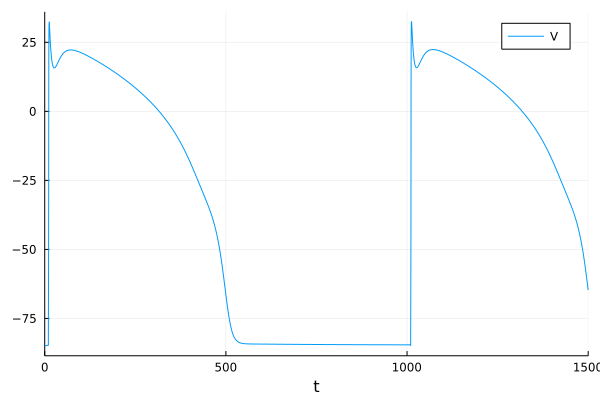

In [15]:
plot(sol, vars=[:V])

# Restore algebraics

In [16]:
algebraics = Vector{typeof(a)}()

for (t, u) in zip(sol.t, sol.u)
    calculate_algebraic!(u, p, t, a)
    append!(algebraics, [deepcopy(a)])
end

In [ ]:
a_matrix = hcat(algebraics...)
algebraics = (;zip(a_syms, eachrow(a_matrix))...);

In [ ]:
plot(algebraics.i_Na)